In [409]:
import numpy as np
import random
import math
from tqdm.notebook import tqdm
import pandas as pd
import torch.nn.functional as F
from gym import spaces
import matplotlib.pyplot as plt
from dataclasses import dataclass

## Env

In [373]:
def angle_between_vectors(v1, v2):
    dot_product = v1[0] * v2[0] + v1[1] * v2[1]
    magnitude_v1 = math.sqrt(v1[0]**2 + v1[1]**2)
    magnitude_v2 = math.sqrt(v2[0]**2 + v2[1]**2)
    
    if magnitude_v1 != 0 and magnitude_v2 != 0:
        cos_theta = dot_product / (magnitude_v1 * magnitude_v2)
        if cos_theta > 1:
                cos_theta = 1
        elif cos_theta < -1:
            cos_theta = -1
        angle_radians = math.acos(cos_theta)
        return angle_radians
    else:
        return 0

def normalize_vector_from_point(x, y, x0, y0):
    # Calcul des composantes du vecteur
    vector_x = x - x0
    vector_y = y - y0
    
    # Calcul de la magnitude
    magnitude = math.sqrt(vector_x**2 + vector_y**2)
    
    # Normalisation
    if magnitude != 0:
        normalized_x = vector_x / magnitude
        normalized_y = vector_y / magnitude
        return (normalized_x, normalized_y)
    else:
        return (0, 0)

In [374]:
class FluidMechanicsEnv:
    
    class Wave:
        def __init__(self, a, T, k) :
            self.a = a                  # Wave amplitude
            self.T = T                  # Wave period
            self.omega = 2 * np.pi / T  # Wave frequency
            self.k = .1   

    class Wind:
        def __init__(self, Ux, Uy, alpha, sigma) :
            self.Ux = Ux                  # Wave amplitude
            self.Uy = Uy                  # Wave period
            self.alpha = alpha            # Wave frequency
            self.sigma = sigma

    def __init__(self, a, T, k,  Ux, Uy, alpha, sigma, x_goal, y_goal, pos0, theta0, dist_threshold=0.1, max_steps=1000, ocean=False, dt=1, max_thrust_speed=1):
        self.t = 0
        self.wave = self.Wave(a, T, k)
        self.wind = self.Wind(Ux, Uy, alpha, sigma)
        self.max_steps = max_steps
        self.dist_threshold = dist_threshold
        self.max_x, self.min_x = 100 , -100  # agent has drifted too far, admit defeat
        self.max_y, self.min_y = 100 , -100 # agent has drifted too far, admit defeat
        self.x_goal, self.y_goal, self.z_goal = x_goal, y_goal, 0 # coordinates of goal
        self.dir_goal = normalize_vector_from_point(self.x_goal, self.y_goal, 0, 0)
        self.done = False
        self.goal_reached = False
        self.steps_count = 0
        self.sum_reward = 0
        self.all_actions = []
        self.pos = pos0
        self.theta = theta0
        self.vel = np.array([0, 0, 0]).astype(np.float32)
        self.thrust = 0 # [0; 1]
        self.rudder = 0.0 # [-pi/4; pi/4]
        self.action = np.array([0, 0])
        self.u_history = []
        self.v_history = []
        self.straight = False
        self.alpha = 0.1
        self.ocean = ocean
        if self.ocean:
            self.state_dim = 9 # u_water, v_water
        else:
            self.state_dim = 7  # x, y, z. 
        self.action_dim = 2  # thrust, rudder angle
        self.dt = dt
        self.max_thrust_speed = max_thrust_speed

        if self.ocean:
            self.observation_space = spaces.Box(low=-100, high=100, shape=(9,), dtype=np.float32)
        else:
            self.observation_space = spaces.Box(low=-100, high=100, shape=(7,), dtype=np.float32)
        
        self.action_space = spaces.Box(low=np.array([0, -np.pi/4]), high=np.array([max_thrust_speed, np.pi/4]), dtype=np.float32)

    def water_surface_level(self, pos) :
        x, _, _ = pos
        eta = self.wave.a * np.sin(self.wave.omega * self.t - self.wave.k * x)
        return eta

    def water_speed(self, pos) :
        x, y, z = pos
        eta = self.water_surface_level(pos)

        u_swell = self.wave.a * self.wave.omega * np.exp(self.wave.k * z) * np.sin(self.wave.omega * self.t - self.wave.k * x)
        w_swell = self.wave.a * self.wave.omega * np.exp(self.wave.k * z) * np.cos(self.wave.omega * self.t - self.wave.k * x)
        
        u_wind = np.random.normal(self.wind.Ux, self.wind.sigma) * np.exp(self.wind.alpha * (z-self.wave.a))
        v_wind = np.random.normal(self.wind.Uy, self.wind.sigma) * np.exp(self.wind.alpha * (z-self.wave.a))

        # u = u + np.random.normal(0, noise, u.shape)
        # v = v + np.random.normal(0, noise, v.shape)
        # w = w + np.random.normal(0, noise, w.shape)

        return u_swell + u_wind, v_wind, w_swell

    def inertia(self, lag = 3):

        if len(self.u_history) > 0 :
            k = np.minimum(lag, len(self.u_history))
            coefs = np.array([1 / (4 ** (i + 1)) for i in reversed(range(k))])
            u = (self.u_history[-k:] * coefs).sum()
            v = (self.v_history[-k:] * coefs).sum()

        else :
            u, v = 0, 0

        return np.array([u, v, 0])
    
    def update_pos(self, action):
        # Sets agent action
        self.thrust = action[0]*self.max_thrust_speed
        self.rudder = action[1]
    
        # Find the water velocity at agent position
        x, y, z = self.pos
        u, v, w = self.water_speed(self.pos)
        self.vel = np.array([u, v, w])

        # Add inertia to the agent's velocity
        self.vel += self.inertia()

        # Perform agent action
        self.theta += self.rudder 
        self.theta %= (2*np.pi) # Update agent's orientation from rudder angle
        u_action = self.thrust * np.cos(self.theta)
        v_action = self.thrust * np.sin(self.theta)
        self.vel += np.array([u_action, v_action, 0])

        # Update velocity history
        self.u_history.append(u)
        self.v_history.append(v)

        # Update agent position
        x += self.vel[0]*self.dt
        y += self.vel[1]*self.dt
        z = self.water_surface_level((x, y, z))

        # Lucas' alignement checks (Lucas double check stp)
        self.dir_goal = normalize_vector_from_point(self.x_goal, self.y_goal, x, y)
        if not self.straight and angle_between_vectors(self.dir_goal, (np.sin(self.theta), np.cos(self.theta))) < 2*self.alpha:
            self.straight = True

        return np.array([x, y, z])
    
    def get_reward(self):
        
        # Calculate euclidian dist to goal Without z coord
        goal_pos = np.array([self.x_goal, self.y_goal])
        dist_to_goal = np.linalg.norm(np.array(self.pos[:2]) - goal_pos)
        dist_to_dir = angle_between_vectors(self.dir_goal, (np.sin(self.theta), np.cos(self.theta)))/np.pi
        ##reward = - (dist_to_goal/100 + np.float64(dist_to_dir))/50

        #TODO: write parametrize reward function based on reward position

        reward = - (dist_to_goal/5000 + (np.exp((1 + np.float64(dist_to_dir))) - 1)/200)
        if dist_to_goal <= self.dist_threshold:
            reward += 10
        if self.straight and angle_between_vectors(self.dir_goal, (np.sin(self.theta), np.cos(self.theta))) >= self.alpha:
            reward -= 0
        return reward
    
    def success(self):
        """Returns True if x,y is near enough goal"""
        goal_pos = np.array([self.x_goal, self.y_goal])
        dist_to_goal = np.linalg.norm(np.array(self.pos[:2]) - goal_pos)
        if  dist_to_goal <= self.dist_threshold:
            return True
        else:
            return False
        
    def admit_defeat(self):
        """Returns True if the agent has drifted too far away from goal"""
        if self.pos[0] > self.max_x or self.pos[0] < self.min_x or self.pos[1] > self.max_y or self.pos[1] < self.min_y:
            return True
        else:
            return False
        
    def step(self, action) :
        
        self.pos = self.update_pos(action)
        self.reward = self.get_reward()
        self.sum_reward += self.reward
        self.steps_count += 1
        self.all_actions += [action]
        self.t += self.dt
        if self.success():
            self.done = True
            self.goal_reached = True

        elif self.admit_defeat() or self.steps_count > self.max_steps:
            self.done = True
        
        if self.ocean: 
            # TODO: Add noise to observation if algo works fine with perfect estimate of wave and winds speed

            # TODO: separate wind and water component

            u_water, v_water, _ = self.water_speed(self.pos)
            return np.concatenate((self.pos, np.array([np.cos(self.theta), np.sin(self.theta)]),  np.array([self.x_goal, self.y_goal]), np.array([u_water, v_water]))), self.reward, self.sum_reward, self.done, self.steps_count, self.all_actions
        
        else:
            return np.concatenate((self.pos, np.array([np.cos(self.theta), np.sin(self.theta)]),  np.array([self.x_goal, self.y_goal]))), self.reward, self.sum_reward, self.done, self.steps_count, self.all_actions
        
    def reset(self):

        self.rudder = 0
        self.thrust = 0  
        self.pos = np.array([0, 0, 0])
        self.done = False
        self.goal_reached = False
        self.steps_count = 0
        self.sum_reward = 0
        self.t = 0
        # Statement: by randomly initilizing theta, we learn beter how to adjust/turn round to reach goal
        self.theta = np.random.uniform(0, 2*np.pi) # if statement false: self.theta = 0
        self.dir_goal = normalize_vector_from_point(self.x_goal, self.y_goal, 0, 0)
        self.straight = False

        if self.ocean: 
            # TODO: Add noise to observation if algo works fine with perfect estimate of wave and winds speed

            # TODO: separate wind and water component

            u_water, v_water, _ = self.water_speed(self.pos)
            return np.concatenate((self.pos, np.array([np.cos(self.theta), np.sin(self.theta)]),  np.array([self.x_goal, self.y_goal]), np.array([u_water, v_water])))
        else:
            return np.concatenate((self.pos, np.array([np.cos(self.theta), np.sin(self.theta)]),  np.array([self.x_goal, self.y_goal])))
        


env = FluidMechanicsEnv(a=0.1, # range 0.1, 0.5, 1, 2, 5
                        T=1, # wave period, range 10 to 20
                        k=0.1, #wave number m^-1: 0.05 to 0.5
                        Ux=0, #wind x component: -2 to 2
                        Uy=0, 
                        alpha=1, # vertical wind decay: around 1
                        sigma=0, # noise wind parameter: around 10% wind speed
                        x_goal=4, 
                        y_goal=4, 
                        pos0=np.array([0, 0, 0]), 
                        theta0=0,
                        dist_threshold=0.2, 
                        max_steps=200, 
                        ocean=False, # if false: still water env. If true: ocean like env
                        dt=1, # time step. For now keep 1, we could go smaller
                        max_thrust_speed = 1# Robot's speed at 100% thrust 
                        )

/Users/valentinbrekke/miniconda3/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [375]:
def make_env():
    def thunk():
        env = FluidMechanicsEnv(
            a=0.1, T=1, k=0.1, Ux=0, Uy=0, alpha=1, sigma=0, 
            x_goal=4, y_goal=4, pos0=np.array([0, 0, 0]), theta0=0,
            dist_threshold=0.2, max_steps=200, ocean=False, dt=1, max_thrust_speed=1
        )
        return env
    return thunk

## Soft Actor Critic

In [376]:
import os
import random
import time
from dataclasses import dataclass

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from stable_baselines3.common.buffers import ReplayBuffer
from torch.utils.tensorboard import SummaryWriter


In [397]:

@dataclass
class Args:

    seed: int = 1
    """seed of the experiment"""
    torch_deterministic: bool = True
    """if toggled, `torch.backends.cudnn.deterministic=False`"""
    cuda: bool = True
    """if toggled, cuda will be enabled by default"""
    track: bool = False
    """if toggled, this experiment will be tracked with Weights and Biases"""
    wandb_project_name: str = "cleanRL"
    """the wandb's project name"""
    wandb_entity: str = None
    """the entity (team) of wandb's project"""
    capture_video: bool = False
    """whether to capture videos of the agent performances (check out `videos` folder)"""

    # Algorithm specific arguments
    env_id: str = "Hopper-v4"
    """the environment id of the task"""
    total_timesteps: int = 100000
    """total timesteps of the experiments"""
    buffer_size: int = int(1e6)
    """the replay memory buffer size"""
    gamma: float = 0.99
    """the discount factor gamma"""
    tau: float = 0.005
    """target smoothing coefficient (default: 0.005)"""
    batch_size: int = 256
    """the batch size of sample from the reply memory"""
    learning_starts: int = 25000
    """timestep to start learning"""
    policy_lr: float = 3e-4
    """the learning rate of the policy network optimizer"""
    q_lr: float = 1e-3
    """the learning rate of the Q network network optimizer"""
    policy_frequency: int = 2
    """the frequency of training policy (delayed)"""
    target_network_frequency: int = 1  # Denis Yarats' implementation delays this by 2.
    """the frequency of updates for the target nerworks"""
    noise_clip: float = 0.5
    """noise clip parameter of the Target Policy Smoothing Regularization"""
    alpha: float = 0.2
    """Entropy regularization coefficient."""
    autotune: bool = True
    """automatic tuning of the entropy coefficient"""


In [398]:
# ALGO LOGIC: initialize agent here:
class SoftQNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod() + np.prod(env.action_space.shape), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x, a):
        x = torch.cat([x, a], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [399]:

LOG_STD_MAX = 2
LOG_STD_MIN = -5


class Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(env.action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(env.action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (log_std + 1)  # From SpinUp / Denis Yarats

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        #print('action', action)
        log_prob = normal.log_prob(x_t)
        #print('logProb', log_prob)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        #print('log_prob', log_prob)
        log_prob = log_prob.sum(-1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean


## Run

In [400]:
args = Args()

# TRY NOT TO MODIFY: seeding
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")


In [401]:
# env setup

# envs = gym.vector.SyncVectorEnv([make_env(args.env_id, args.seed, 0, args.capture_video, run_name)])
# assert isinstance(envs.single_action_space, gym.spaces.Box), "only continuous action space is supported"

# max_action = float(envs.single_action_space.high[0])


In [402]:
envs = make_env()()

/Users/valentinbrekke/miniconda3/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [403]:
actor = Actor(envs).to(device)
qf1 = SoftQNetwork(envs).to(device)
qf2 = SoftQNetwork(envs).to(device)
qf1_target = SoftQNetwork(envs).to(device)
qf2_target = SoftQNetwork(envs).to(device)
qf1_target.load_state_dict(qf1.state_dict())
qf2_target.load_state_dict(qf2.state_dict())
q_optimizer = optim.Adam(list(qf1.parameters()) + list(qf2.parameters()), lr=args.q_lr)
actor_optimizer = optim.Adam(list(actor.parameters()), lr=args.policy_lr)


In [404]:
import numpy as np
import torch

class ReplayBuffer(object):
	def __init__(self, state_dim, action_dim, max_size=int(1e9)):
		self.max_size = max_size
		self.ptr = 0
		self.size = 0

		self.state = np.zeros((max_size, state_dim))
		self.action = np.zeros((max_size, action_dim))
		self.next_state = np.zeros((max_size, state_dim))
		self.reward = np.zeros((max_size, 1))
		self.not_done = np.zeros((max_size, 1))

		self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


	def add(self, state, action, next_state, reward, done):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.next_state[self.ptr] = next_state
		self.reward[self.ptr] = reward
		self.not_done[self.ptr] = 1. - done

		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)


	def sample(self, batch_size):
		ind = np.random.randint(0, self.size, size=batch_size)

		return (
			torch.FloatTensor(self.state[ind]).to(self.device),
			torch.FloatTensor(self.action[ind]).to(self.device),
			torch.FloatTensor(self.next_state[ind]).to(self.device),
			torch.FloatTensor(self.reward[ind]).to(self.device),
			torch.FloatTensor(self.not_done[ind]).to(self.device)
		)

In [405]:
# Automatic entropy tuning
if args.autotune:
    target_entropy = -torch.prod(torch.Tensor(envs.action_space.shape).to(device)).item()
    log_alpha = torch.zeros(1, requires_grad=True, device=device)
    alpha = log_alpha.exp().item()
    a_optimizer = optim.Adam([log_alpha], lr=args.q_lr)
else:
    alpha = args.alpha

envs.observation_space.dtype = np.float32

rb = ReplayBuffer(envs.observation_space.shape[0], envs.action_space.shape[0])

In [406]:
# TRY NOT TO MODIFY: start the game
obs = envs.reset()
start_time = time.time()
for global_step in range(args.total_timesteps):
    # ALGO LOGIC: put action logic here
    if global_step < args.learning_starts:
        actions = np.array(envs.action_space.sample())
    else:
        actions, _, _ = actor.get_action(torch.Tensor(obs).to(device))
        actions = actions.detach().cpu().numpy()
    #print('actions', actions)

    # TRY NOT TO MODIFY: execute the game and log data.
    #print('envs.step(actions)', envs.step(actions))
    next_obs, rewards, sum_reward, terminations, steps_count, all_actions, = envs.step(actions) # removed truncations, infos 

    # TRY NOT TO MODIFY: record rewards for plotting purposes
    # if "final_info" in infos:
    #     for info in infos["final_info"]:
    #         print(f"global_step={global_step}, episodic_return={info['episode']['r']}")
    #         writer.add_scalar("charts/episodic_return", info["episode"]["r"], global_step)
    #         writer.add_scalar("charts/episodic_length", info["episode"]["l"], global_step)
    #         break

    # TRY NOT TO MODIFY: save data to reply buffer; handle `final_observation`
    #real_next_obs = next_obs.copy()
    # for idx, trunc in enumerate(truncations):
    #     if trunc:
    #         real_next_obs[idx] = infos["final_observation"][idx]

    # Check for termination and reset environments if needed
    # if any(terminations):
    #     for idx, done in enumerate(terminations):
    #         if done:
    #             obs[idx] = envs.reset(idx)

    # Rest of the training logic...
    rb.add(obs, actions, next_obs, rewards, terminations)

    # TRY NOT TO MODIFY: CRUCIAL step easy to overlook
    obs = next_obs

    # if done then reset
    if terminations:
        obs = envs.reset()

    # ALGO LOGIC: training.
    if global_step > args.learning_starts:
        data = rb.sample(args.batch_size)
        with torch.no_grad():
            next_state_actions, next_state_log_pi, _ = actor.get_action(data[2])
            #print('next_state_log_pi', next_state_log_pi.shape)
            qf1_next_target = qf1_target(data[2], next_state_actions)
            #print('qf1_next_target', qf1_next_target.shape)
            qf2_next_target = qf2_target(data[2], next_state_actions)
            #print('qf2_next_target', qf2_next_target.shape)
            min_qf_next_target = torch.min(qf1_next_target, qf2_next_target) - alpha * next_state_log_pi
            #print('min_qf_next_target', min_qf_next_target.shape)
            next_q_value = data[3].flatten() + (1 - data[4].flatten()) * args.gamma * (min_qf_next_target).view(-1)
            #print('next_q', next_q_value.shape)

        qf1_a_values = qf1(data[0], data[1]).view(-1)
        qf2_a_values = qf2(data[0], data[1]).view(-1)
        qf1_loss = F.mse_loss(qf1_a_values, next_q_value)
        qf2_loss = F.mse_loss(qf2_a_values, next_q_value)
        qf_loss = qf1_loss + qf2_loss

        # optimize the model
        q_optimizer.zero_grad()
        qf_loss.backward()
        q_optimizer.step()

        if global_step % args.policy_frequency == 0:  # TD 3 Delayed update support
            # print(global_step)
            for _ in range(args.policy_frequency):  # compensate for the delay by doing 'actor_update_interval' instead of 1
                pi, log_pi, _ = actor.get_action(data[0])
                qf1_pi = qf1(data[0], pi)
                qf2_pi = qf2(data[0], pi)
                min_qf_pi = torch.min(qf1_pi, qf2_pi)
                actor_loss = ((alpha * log_pi) - min_qf_pi).mean()

                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()

                if args.autotune:
                    with torch.no_grad():
                        _, log_pi, _ = actor.get_action(data[0])
                    alpha_loss = (-log_alpha.exp() * (log_pi + target_entropy)).mean()

                    a_optimizer.zero_grad()
                    alpha_loss.backward()
                    a_optimizer.step()
                    alpha = log_alpha.exp().item()

        # update the target networks
        if global_step % args.target_network_frequency == 0:
            for param, target_param in zip(qf1.parameters(), qf1_target.parameters()):
                target_param.data.copy_(args.tau * param.data + (1 - args.tau) * target_param.data)
            for param, target_param in zip(qf2.parameters(), qf2_target.parameters()):
                target_param.data.copy_(args.tau * param.data + (1 - args.tau) * target_param.data)

        # if global_step % 100 == 0:
        #     writer.add_scalar("losses/qf1_values", qf1_a_values.mean().item(), global_step)
        #     writer.add_scalar("losses/qf2_values", qf2_a_values.mean().item(), global_step)
        #     writer.add_scalar("losses/qf1_loss", qf1_loss.item(), global_step)
        #     writer.add_scalar("losses/qf2_loss", qf2_loss.item(), global_step)
        #     writer.add_scalar("losses/qf_loss", qf_loss.item() / 2.0, global_step)
        #     writer.add_scalar("losses/actor_loss", actor_loss.item(), global_step)
        #     writer.add_scalar("losses/alpha", alpha, global_step)
        #     print("SPS:", int(global_step / (time.time() - start_time)))
        #     writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)
        #     if args.autotune:
        #         writer.add_scalar("losses/alpha_loss", alpha_loss.item(), global_step)
        if global_step % 100 == 0:
            print(f"Step: {global_step}, QF1 Values Mean: {qf1_a_values.mean().item()}")
            print(f"Step: {global_step}, QF2 Values Mean: {qf2_a_values.mean().item()}")
            print(f"Step: {global_step}, QF1 Loss: {qf1_loss.item()}")
            print(f"Step: {global_step}, QF2 Loss: {qf2_loss.item()}")
            print(f"Step: {global_step}, QF Loss: {qf_loss.item() / 2.0}")
            print(f"Step: {global_step}, Actor Loss: {actor_loss.item()}")
            print(f"Step: {global_step}, Alpha: {alpha}")
            sps = int(global_step / (time.time() - start_time))
            print(f"Step: {global_step}, SPS (Samples Per Second): {sps}")
            if args.autotune:
                print(f"Step: {global_step}, Alpha Loss: {alpha_loss.item()}")

Step: 25100, QF1 Values Mean: -0.03382384404540062
Step: 25100, QF2 Values Mean: -0.04125746339559555
Step: 25100, QF1 Loss: 0.0015465763863176107
Step: 25100, QF2 Loss: 0.001732702017761767
Step: 25100, QF Loss: 0.0016396392602473497
Step: 25100, Actor Loss: -0.30662864446640015
Step: 25100, Alpha: 0.904549777507782
Step: 25100, SPS (Samples Per Second): 12471
Step: 25100, Alpha Loss: 2.1492197513580322
Step: 25200, QF1 Values Mean: -0.011170154437422752
Step: 25200, QF2 Values Mean: -0.013351473025977612
Step: 25200, QF1 Loss: 0.0012947500217705965
Step: 25200, QF2 Loss: 0.0007259603589773178
Step: 25200, QF Loss: 0.0010103551903739572
Step: 25200, Actor Loss: -0.3003438115119934
Step: 25200, Alpha: 0.8227711319923401
Step: 25200, SPS (Samples Per Second): 9104
Step: 25200, Alpha Loss: 1.9758437871932983
Step: 25300, QF1 Values Mean: -0.02567457966506481
Step: 25300, QF2 Values Mean: -0.024399375542998314
Step: 25300, QF1 Loss: 0.0014386600814759731
Step: 25300, QF2 Loss: 0.001173907

In [407]:
def plot_trajectory(trained_actor):
    done = False
    obs = env.reset()
    x, y = [obs[0]], [obs[1]]

    while not done: 
        actions, _, _ = trained_actor.get_action(torch.Tensor(obs).unsqueeze(0).to(device))
        actions = actions.detach().cpu().numpy()
        next_obs, rewards, sum_reward, terminations, steps_count, all_actions, = envs.step(actions[0]) # removed truncations, infos 
        x.append(next_obs[0])
        y.append(next_obs[1])
        
        obs = next_obs
        done = terminations
       
    fig = plt.figure(figsize = (10, 6))
    plt.grid(True)
    plt.scatter([env.x_goal], [env.y_goal], marker = "o", color = "r")
    plt.plot(x, y, 'k-o')
    plt.show()


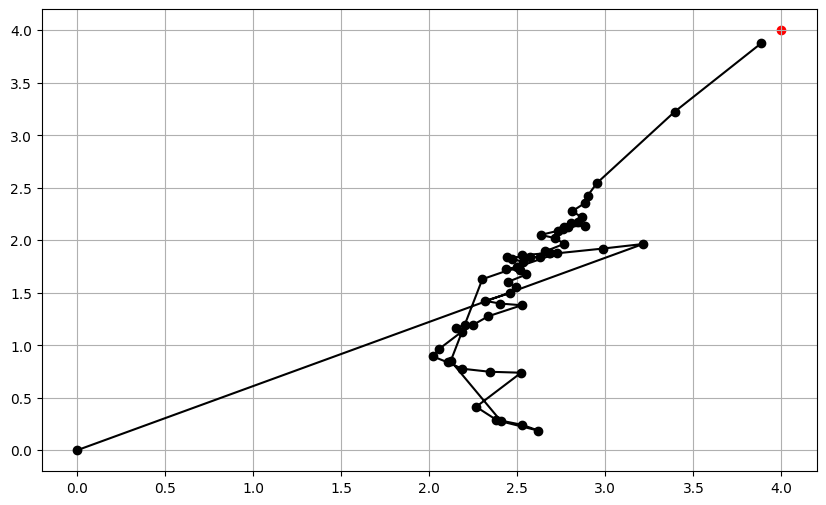

In [408]:
plot_trajectory(actor)

## Main run function

In [ ]:
def run_SAC(seed=0):